# Instance Segmentation CV model to detect bottle glass defects with Azure ML AutoML for Images

We will use build and train an Instance Segmentation Custom Vision model using AutoML for Images in order to detect any defects from glass materials.

<img src="https://raw.githubusercontent.com/retkowsky/InstanceSegmentation/main/captures/example.jpg?">

> Important: This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews.

Images are available here: https://github.com/retkowsky/InstanceSegmentation/tree/main/images<br>Then you need to label them using for example Azure ML Data Labelling

In [1]:
import datetime
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image
import requests
import uuid
import azureml.core
from IPython.display import display_javascript, display_html, display
from azureml.core import Workspace, Datastore, Dataset

In [2]:
import sys
print("This notebook was made with Python:", sys.version)

This notebook was made with Python: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [3]:
now = datetime.datetime.now()
print("Today:", now)

Today: 2022-01-04 09:37:39.432778


## 1. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

## AutoML for Images environment setup
Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

In [4]:
#Version
import azureml.core
print("Azure ML version:", azureml.core.VERSION)

Azure ML version: 1.35.0


In [5]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
print("You are using Azure ML workspace:", ws.name)

You are using Azure ML workspace: azuremlvision


## 2. Azure ML GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [6]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoMLGPU"

t1 = datetime.datetime.now()

try:
    compute_target = ws.compute_targets[cluster_name]
    print(t1, "Found existing compute target.")

except KeyError:
    print(t1, "Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=1800,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

t2 = datetime.datetime.now()
print()
print(t2, "Time:", t2 - t1)

2022-01-04 09:37:53.110922 Creating a new compute target...
InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned

2022-01-04 09:38:20.786558 Time: 0:00:27.675636


In [7]:
print("Azure ML GPU Compute Cluster is available:", compute_target.name)

Azure ML GPU Compute Cluster is available: AutoMLGPU


## 3. Azure ML Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [8]:
from azureml.core import Experiment
experiment_name = "AutoML-InstanceSegmentation-GlassDefect"
experiment = Experiment(ws, name=experiment_name)

In [9]:
print("Results will be available in this Azure ML experiment:", experiment_name)
experiment

Results will be available in this Azure ML experiment: AutoML-InstanceSegmentation-GlassDefect


Name,Workspace,Report Page,Docs Page
AutoML-InstanceSegmentation-GlassDefect,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 4. Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data.

We have defined the segmentation regions we want to detect using Azure ML data labelling.

<img src="https://github.com/retkowsky/InstanceSegmentation/blob/main/captures/datalabelling.jpg?raw=true">

In [10]:
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

fulldataset = Dataset.get_by_name(ws, name='glassdefect_20211220_122800') # Name of your labelled dataset
df = fulldataset.to_pandas_dataframe() # Convert it to a pandas dataframe

In [11]:
df.shape

(50, 3)

In [12]:
df.head(10)

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://defect (17).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...","[1.0, 1.0]"
1,StreamInfo(AmlDatastore://defect (10).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...","[1.0, 1.0]"
2,StreamInfo(AmlDatastore://defect (4).png[{'sub...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
3,StreamInfo(AmlDatastore://defect (28).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
4,StreamInfo(AmlDatastore://defect (11).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
5,StreamInfo(AmlDatastore://defect (36).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
6,StreamInfo(AmlDatastore://defect (37).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
7,StreamInfo(AmlDatastore://defect (50).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
8,StreamInfo(AmlDatastore://defect (7).png[{'sub...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
9,StreamInfo(AmlDatastore://defect (32).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]


In [13]:
fulldataset.to_pandas_dataframe()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://defect (17).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...","[1.0, 1.0]"
1,StreamInfo(AmlDatastore://defect (10).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...","[1.0, 1.0]"
2,StreamInfo(AmlDatastore://defect (4).png[{'sub...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
3,StreamInfo(AmlDatastore://defect (28).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
4,StreamInfo(AmlDatastore://defect (11).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
5,StreamInfo(AmlDatastore://defect (36).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
6,StreamInfo(AmlDatastore://defect (37).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
7,StreamInfo(AmlDatastore://defect (50).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
8,StreamInfo(AmlDatastore://defect (7).png[{'sub...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]
9,StreamInfo(AmlDatastore://defect (32).png[{'su...,"[{'label': 'defect', 'isCrowd': False, 'polygo...",[1.0]


## 5. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `maskrcnn`), you can specify the config for your AutoML Image runs as follows:

In [14]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters

In [15]:
image_config_maskrcnn = AutoMLImageConfig(
    task=ImageTask.IMAGE_INSTANCE_SEGMENTATION, # This is an instance segmentation task
    compute_target = compute_target, # Azure ML GPU cluster to use
    training_data = fulldataset, # images
    #validation_data = validation_dataset, # by default 20% is the for the validation or you can specify a val dataset 
    experiment_timeout_hours = 0.5, # Timeout in hours
    hyperparameter_sampling = GridParameterSampling({"model_name": choice("maskrcnn_resnet152_fpn")}),
    iterations = 1, # 1 is for the default hyperparameter values
)

## 6. Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [16]:
t1 = datetime.datetime.now()
print(t1, "Running AutoML for Images...\n")

automl_image_run = experiment.submit(image_config_maskrcnn)
automl_image_run.wait_for_completion(wait_post_processing=True)

t2 = datetime.datetime.now()
print()
print(t2, "Training time:", t2 - t1)

2022-01-04 09:43:17.536481 Running AutoML for Images...

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-GlassDefect,AutoML_694ff7ff-2a94-40b1-a433-1fef66010463,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



2022-01-04 10:00:25.612740 Training time: 0:17:08.076259


### Interactive widget for the results

In [17]:
from azureml.widgets import RunDetails
RunDetails(automl_image_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### [Optional] Hyperparameter sweeping for your AutoML models for computer vision tasks
In this example, we use the AutoMLImageConfig to train an Instance Segmentation model using `maskrcnn_resnet50_fpn` which is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories.

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target, which has been previously set up using 4 nodes.  Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "model_name": choice("maskrcnn_resnet50_fpn"),
    "learning_rate": uniform(0.0001, 0.001),
    #'warmup_cosine_lr_warmup_epochs': choice(0, 3),
    "optimizer": choice("sgd", "adam", "adamw"),
    "min_size": choice(350, 490),
}

tuning_settings = {
    "iterations": 10,
    "max_concurrent_iterations": 2,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_INSTANCE_SEGMENTATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

automl_image_run = experiment.submit(automl_image_config)

automl_image_run.wait_for_completion(wait_post_processing=True)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab:

In [18]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-GlassDefect,AutoML_694ff7ff-2a94-40b1-a433-1fef66010463_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


## 7. Register the model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [19]:
model_desc = "Instance Segmentation CV model for detecting glass defect"

model_tags = {"Data" : "Images", 
              "Context" : "Glass Defect Detection",
              "Task" : "Instance Segmentation",
              "Framework" : "Azure ML AutoML for Images"}

In [20]:
t1 = datetime.datetime.now()
print(t1, "Registering the model...\n")

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]

model = best_child_run.register_model(model_name=model_name, 
                                      model_path="outputs/model.pt", # Model to register (PyTorch format)
                                      description=model_desc,
                                      tags=model_tags)
t2 = datetime.datetime.now()
print()
print(t2, "Time to register the model:", t2 - t1)

2022-01-04 10:00:53.154887 Registering the model...


2022-01-04 10:00:55.068142 Time to register the model: 0:00:01.913255


In [21]:
model.id

'AutoML694ff7ff20:1'

In [22]:
model.version

1

In [23]:
model.description

'Instance Segmentation CV model for detecting glass defect'

In [24]:
model.tags

{'Data': 'Images',
 'Context': 'Glass Defect Detection',
 'Task': 'Instance Segmentation',
 'Framework': 'Azure ML AutoML for Images'}

## 8. Model results

In [25]:
automl_image_run.get_properties

<bound method Run.get_properties of Run(Experiment: AutoML-InstanceSegmentation-GlassDefect,
Id: AutoML_694ff7ff-2a94-40b1-a433-1fef66010463,
Type: automl,
Status: Completed)>

In [26]:
metricsdf = pd.DataFrame(automl_image_run.get_metrics()) # Convert to a pandas df
metricsdf

,recall,precision,per_label_metrics,mean_average_precision
0,0.09091,0.02564,"{1: {'precision': 0.02564, 'recall': 0.09091, ...",0.01136
1,1.00000,0.06918,"{1: {'precision': 0.06918, 'recall': 1.0, 'ave...",0.70576
2,1.00000,0.18966,"{1: {'precision': 0.18966, 'recall': 1.0, 'ave...",0.72281
3,0.90909,0.41667,"{1: {'precision': 0.41667, 'recall': 0.90909, ...",0.89256
4,0.90909,0.38462,"{1: {'precision': 0.38462, 'recall': 0.90909, ...",0.90083
5,0.90909,0.47619,"{1: {'precision': 0.47619, 'recall': 0.90909, ...",0.84848
6,0.90909,0.38462,"{1: {'precision': 0.38462, 'recall': 0.90909, ...",0.87879
7,0.90909,0.55556,"{1: {'precision': 0.55556, 'recall': 0.90909, ...",0.90083
8,0.90909,0.62500,"{1: {'precision': 0.625, 'recall': 0.90909, 'a...",0.89394
9,0.90909,0.76923,"{1: {'precision': 0.76923, 'recall': 0.90909, ...",0.86869


In [27]:
metricsdf.tail(1)

,recall,precision,per_label_metrics,mean_average_precision
10,0.90909,0.58824,"{1: {'precision': 0.58824, 'recall': 0.90909, ...",0.84848


In [28]:
%mkdir results

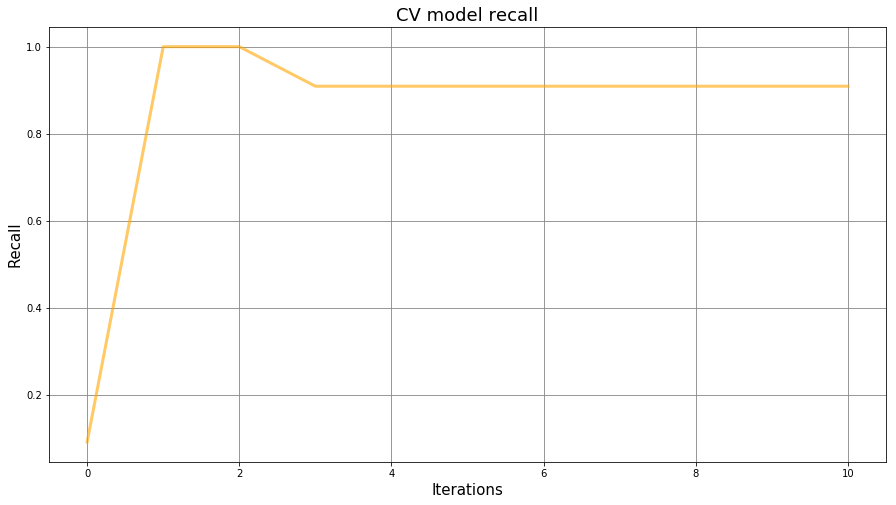

In [30]:
%matplotlib inline

plt.figure(figsize = (15,8))
plt.plot(metricsdf['recall'], 'orange', lw=3, alpha=.6)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.title('CV model recall', fontsize=18)
plt.grid(color='gray', linestyle='-', linewidth=0.8)
plt.savefig('results/recall.png') # Saving image
automl_image_run.log_image(name='results/recall.png', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

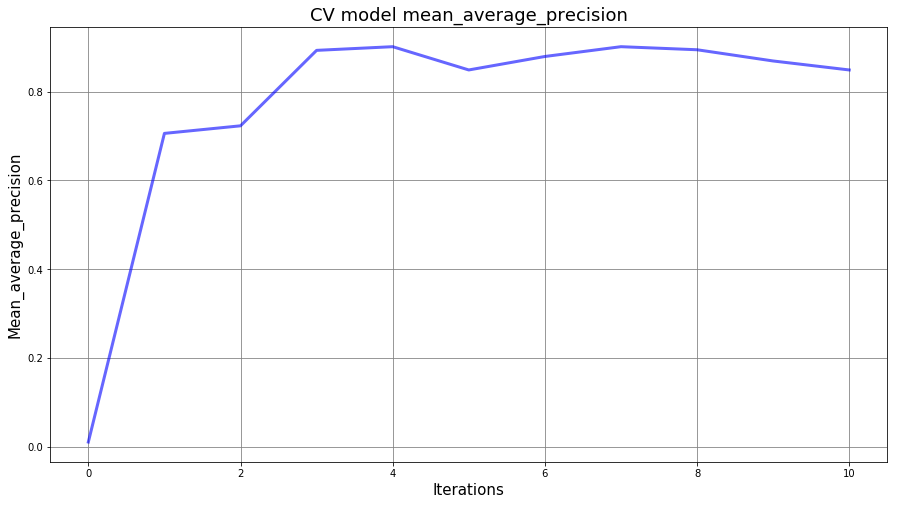

In [31]:
%matplotlib inline

plt.figure(figsize = (15,8))
plt.plot(metricsdf['mean_average_precision'], 'blue', lw=3, alpha=.6)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Mean_average_precision', fontsize=15)
plt.title('CV model mean_average_precision', fontsize=18)
plt.grid(color='gray', linestyle='-', linewidth=0.8)
plt.savefig('results/mean_average_precision.png') # Saving image
automl_image_run.log_image(name='results/mean_average_precision.png', plot=plt) # Logging the graph

plt.show()

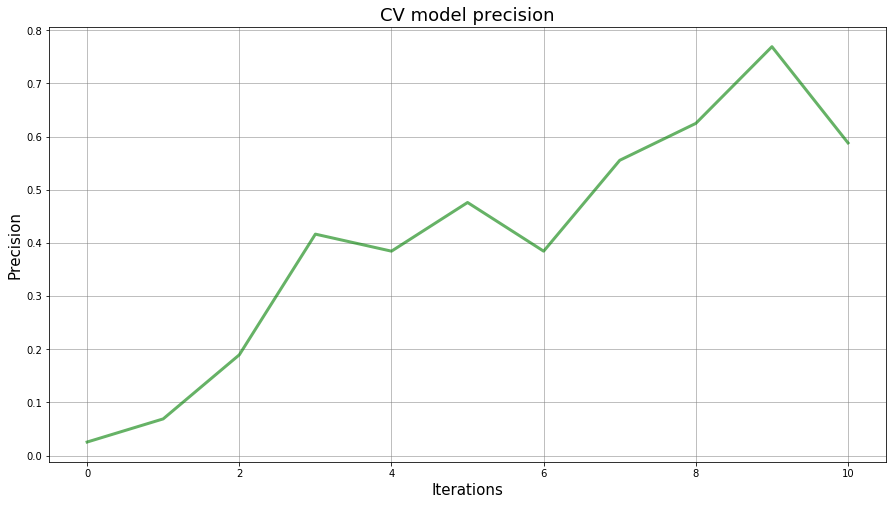

In [32]:
%matplotlib inline

plt.figure(figsize = (15,8))
plt.plot(metricsdf['precision'], 'green', lw=3, alpha=.6)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('CV model precision', fontsize=18)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('results/precision.png') # Saving image
automl_image_run.log_image(name='results/precision.png', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

In [33]:
experiment

Name,Workspace,Report Page,Docs Page
AutoML-InstanceSegmentation-GlassDefect,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


### Download artifacts (optional)

In [34]:
%mkdir model

In [39]:
# PyTorch model
best_child_run.download_file("outputs/model.pt", output_file_path="model/model.pt")
!ls model/model.pt -lh

-rwxrwxrwx 1 root root 600M Jan  4 10:02 model/model.pt


In [36]:
# Computer Vision Labels
best_child_run.download_file("train_artifacts/labels.json", output_file_path="model/labels.json")
!ls model/labels.json -lh

-rwxrwxrwx 1 root root 20 Jan  4 10:02 model/labels.json


In [37]:
with open(os.path.join('model/labels.json'), 'r') as f:
    print(f.read())

["--bg--", "defect"]


In [38]:
# ONNX model (for local inference)
best_child_run.download_file("train_artifacts/model.onnx", output_file_path="model/model.onnx")
!ls model/model.onnx -lh

-rwxrwxrwx 1 root root 301M Jan  4 10:02 model/model.onnx


In [40]:
# Model metrics
best_child_run.download_file("train_artifacts/per_label_metrics.json", output_file_path="model/per_label_metrics.json")
!ls model/per_label_metrics.json -lh

-rwxrwxrwx 1 root root 349 Jan  4 10:02 model/per_label_metrics.json


In [41]:
with open(os.path.join('model/per_label_metrics.json'), 'r') as f:
    print(f.read())

{"defect": {"precision": [0.02564, 0.06918, 0.18966, 0.41667, 0.38462, 0.47619, 0.38462, 0.55556, 0.625, 0.76923, 0.58824], "recall": [0.09091, 1.0, 1.0, 0.90909, 0.90909, 0.90909, 0.90909, 0.90909, 0.90909, 0.90909, 0.90909], "average_precision": [0.01136, 0.70576, 0.72281, 0.89256, 0.90083, 0.84848, 0.87879, 0.90083, 0.89394, 0.86869, 0.84848]}}


In [42]:
# Training datasets
best_child_run.download_file("train_artifacts/train_df.csv", output_file_path="model/train_df.csv")
!ls model/train_df.csv -lh

-rwxrwxrwx 1 root root 32K Jan  4 10:02 model/train_df.csv


In [43]:
# Validation datasets
best_child_run.download_file("train_artifacts/val_df.csv", output_file_path="model/val_df.csv")
!ls model/val_df.csv -lh

-rwxrwxrwx 1 root root 8.1K Jan  4 10:02 model/val_df.csv


## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

### 9.1 You will need to first create an AKS compute cluster or use an existing AKS cluster.

You can use either GPU or CPU VM SKUs for your deployment cluster

In [44]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

aks_name = "cluster-aks-d3v2"

t1 = datetime.datetime.now()
print(t1, "Creating or using AKS...\n")

try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing AKS")

except ComputeTargetException:
    print("Creating a new compute target...")
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

t2 = datetime.datetime.now()
print()
print(t2, "Time:", t2 - t1)

2022-01-04 10:02:38.912924 Creating or using AKS...

Found existing AKS

2022-01-04 10:02:39.023577 Time: 0:00:00.110653


Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [45]:
from azureml.core.model import InferenceConfig

best_child_run.download_file("outputs/scoring_file_v_1_0_0.py", output_file_path="model/score.py")

environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="model/score.py", environment=environment)

In [46]:
!ls model/score.py -lh

-rwxrwxrwx 1 root root 2.0K Jan  4 10:02 model/score.py


In [47]:
with open(os.path.join('model/score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.object_detection.writers.score import _score_with_model

TASK_TYPE = 'image-instance-segmentation'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = Model.get_model_pat

### 9.2 You can then deploy the model as an AKS web service:

In [48]:
aks_modelname = "automl-instanceseg-glass"
aks_description = "Instance Segmentation computer vision model to detect Glass Defects"

In [49]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

t1 = datetime.datetime.now()
print(t1, "Deploying the model into AKS...\n")

# Deploy the model from the best run as an AKS web service
aks_config = AksWebservice.deploy_configuration(
            autoscale_enabled=True, 
            cpu_cores=1, 
            memory_gb=5, 
            enable_app_insights=True, 
            description=aks_description )

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name=aks_modelname,
    overwrite=True,
)

aks_service.wait_for_deployment(show_output=True)

t2 = datetime.datetime.now()
print()
print(t2, "Time to deploy the model into Azure Kubernetes Service:", t2 - t1)

2022-01-04 10:02:51.646623 Deploying the model into AKS...

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-01-04 10:02:57+00:00 Creating Container Registry if not exists.
2022-01-04 10:02:57+00:00 Registering the environment.
2022-01-04 10:02:58+00:00 Use the existing image.
2022-01-04 10:02:59+00:00 Creating resources in AKS.
2022-01-04 10:03:00+00:00 Submitting deployment to compute.
2022-01-04 10:03:01+00:00 Checking the status of deployment automl-instanceseg-glass..
2022-01-04 10:03:24+00:00 Checking the status of inference endpoint automl-instanceseg-glass.
Succeeded
AKS service creation operation finished, operation "Succeeded"

2022-01-04 10:03:29.550275 Time to deploy the model into Azure Kubernetes Service: 0:00:37.903652


In [50]:
print("AKS service status:", aks_service.state)

AKS service status: Healthy


### Additional informations

In [51]:
#print("Computer Vision model endpoint:", aks_service.scoring_uri)
#print("Computer Vision model endpoint properties:", aks_service.properties)
#print("AKS Logs:", aks_service.get_logs())

## 10. Use this notebook to call the CV deployed model:

Calling Glass Defect CV model.ipynb

## 11. Additional tasks

In [52]:
#Let's delete our Azure ML GPU compute cluster
compute_target.delete()

In [ ]:
#You can also delete the service (don't do it now!)
#aks_service.delete()

> End